# Simulation code

First need to account for the results page being the values, We can pass in a dictionary of edges with their possible values to convert everything to -1 and 1. We will make use of the text files. Furthermore we still need to determine what the output (y) values are. 
To get the range we are going to read from a text file to set the values to -1 and one throughout the file
Work will be done to the 3rd degree

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image

Here we will write the script that takes the catanated files from gaea and clean it to perform further analysis

In [2]:
'''
aggregate Factorial
Args: inFile: CSV file of the aggregate sums of results of the 2^K factorial test
      numRuns: otherwise known as k, the number of experiments run
      constNodes: List of the nodes that have no inbound edges and thus have a constant value throughout
      outFile: name of the output file for the variance
returns: NULL

Desc: Takes in the aggregate sums from a 2^k factorial test run using the greyMap code. Sums the set of sums for each 
non-constant node and processes the results to get the total variance on each edge for a node
'''

def aggregateFactorial(inFile, numRuns, constNodes, outFile):
    debug = False
    variationDict = {}
    f = open(inFile)
    header = f.readline() #save the header
    firstSet = True#checks if it is the first set of results for adding keys
    for line in f:
        content = line.split(',')
        key = content[0]#save the key for deictionary access
        content = content[1:]#drop the index off content
        
        if key in constNodes:#check if that node remains constant the entire time
            continue
        
        if firstSet:
            
            if key == 'index':#first checks to see if its the first file. initializes lists for the summations
                first = False
                continue
            variationDict[key] = [0] * len(content)#make list of 0's for sums
                
        if key == 'index': #if a header line
            continue
        
        
        for i in range(0,len(content)):            
            variationDict[key][i] += float(content[i])#get the sums across the line
            
            
    f.close()#no longer need to read from file     
    #At this point we have all the sums from the runs
    for key in variationDict:
        totalVar = 0#to track total variance, is reset for each stable node that needs calculation
        for i in range(0,len(variationDict[key])):
            variationDict[key][i] = variationDict[key][i]/float(numRuns)#make sure stays as float
            variationDict[key][i] = variationDict[key][i]**2 # all work needs the squared version
       
        #get the total variation and variation on each edge for the node
        totalVar = sum(variationDict[key]) * numRuns
        for i in range(0,len(variationDict[key])):
            variationDict[key][i] = (variationDict[key][i]*numRuns)/totalVar#make sure stays as float
            
  
    
    g = open(outFile,'w')
    #write the output file, row per each node stabilized on. Get the percent, any value below .01% is set to 0.
    writeLine = ''
    First = True
    g.write(header)
    
    for key in variationDict:
        writeLine = ''
        writeLine += key
        for element in variationDict[key]:
            if (element*100) < .01:
                writeLine += ',' + '0.00'
            else:
                writeLine += ',' + str(element*100)
            
        writeLine += '\n'
        g.write(writeLine)
    g.close()
    

# Threshold To return edges

In [3]:
'''
Will open the csv file of the 2k test.
csv: csv file of 2k variance results
stableConcepts: list of strings of the stabilizing concepts
threshold: the value that the edges at some degree must be above the threshold
Will find the edges that don't make the threshold and return them to the user. does not need to create a file
Output is a dictionary of the stable concepts. True means that edge was above the threshold with the summation of up to 3rd
degree while false means the summation did not break the threhol
'''
def Threshold(csv, stableConcepts, threshold):
    varDict = {}
    stableDict ={}
    
    for element in stableConcepts:
        stableDict[element] = []
    
    f = open(csv)
    header = f.readline()
    header = header.split(',')
    for element in header:
        if element == 'index':#remove index header from dictionary
            continue
            
        #find the 1st degree of edges. amount = k
        if '&' not in element:
            varDict[element] = []
            
        #get the index for each ocurence of the edge in the rows. will be used for computing sums for threshold
        for edge in element.split('&'):
            edge = edge.strip('\n')
            varDict[edge].append(header.index(element))

    #for each element we stabilized on find if the initial edge reached 5% or the sum of all its parts is greater than 5% 
    for line in f:
        
        content = line.split(',')
        for key in varDict:
            sum = 0.0
            for index in varDict[key]:
                #print content[index]
                sum += float(content[index])
                
            if sum > threshold:
                stableDict[content[0]].append(key)#True means that the value is above th threshold
                
    f.close()
    return stableDict

In [4]:
'''
Post-processing of the results returned by the Threshold function (above)
Given a list of concepts (first argument), find the edges that are in AT LEAST one of these concepts
'''
def unionResults(concepts, dictionaryThreshold):
    returnList = []
    
    for element in concepts:
        for edge in dictionaryThreshold[element]:
            if edge not in returnList:
                returnList.append(edge)
                
    return returnList

# Example using the simulation code
This corresponds to case study 1 in our paper. All other case studies are run remotely on an HPC.

In this notebook we show the work to be done after the $2^{k}$ factorial design has been completed. In the following cell we show what a call for the factorial design function would look like but is not implemented in this notebook.

In [5]:
'''
This following code would be to run the 2^k factorial design and for a text file for a FGCM, 0 is the starting point,
256 is the amount of FCM's ro tun on a machine. It is 2^k here for running on a singular machine, so k = 8 in this case.
The last argument is the nme of the output file.
'''
greyMap("Case_Study_1_AllStabilizes.txt", 0, 256, "CS_1_results.csv")

NameError: name 'greyMap' is not defined

The CS_1_results.csv will look like the following image. If the program was run on a cluster you would just aggregate all the results into a single file that would look like the second image. Both types of files are processed the same way.

In [6]:
#2^k design results with 1 computer
Image(filename='results.png')

FileNotFoundError: [Errno 2] No such file or directory: 'results.png'

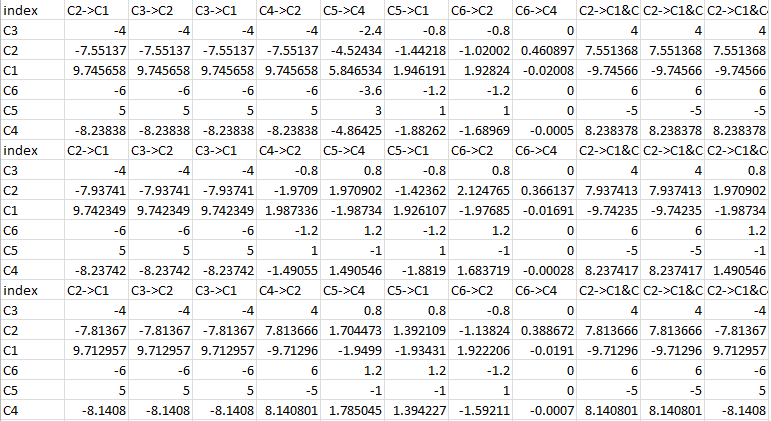

In [30]:
#2^k results with a cluster
Image(filename='results_aggregated.png')

With these results we call the aggregateFactorial method which finalizes the factorial design and gets the total variation caused by each edge and their interactions up to $3^{rd}$ degree. We pass it the input file, $2^k$, a list of nodes that have no input edges. We then remove those from processing to speed up the results. The final argument is again the output file. 

In [ ]:
aggregateFactorial('CS_1_results.csv',256,['C3','C6','C5'], 'CS_1_Variation.csv')

We will get an output file of the following image. To simplify the viewing results we set all values that are below 0.01% to 0. 

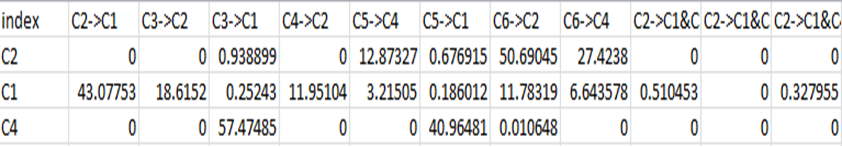

In [31]:
Image(filename='variation.png')

Once we have that the next things we need to do is check whether or not the summation of the variation of an edge and all of its interactions are above a certain predetermined threshold. In this set of examples we will consider the edges that contribute to at least 5% of the variance. Note that the number of edges that contribute more than 5% will never be more than **k**, since we use the summation of the edges and their interactions.

In [ ]:
k = Threshold('CS_1_Variation.csv', ['C2','C1','C4'],5)
print k
print 'The number of edges above the threshold is: ', len(k)

Last if there are multiple nodes that you are stabilizing on, then you want to union the edges that are important to each of the stabilizing nodes. 

In [ ]:
x = unionResults(['C1','C2','C4'], k)
print 'The number of edges important to all stabilizing contents is: ', len(x)